## Цель данного плейбука - получить оценки из API кинопоиска и сравнить их с оценками из IMDb и netflix из исходного датасета.

### Использование внешнего НЕОФИЦИАЛЬНОГО источника для получения инфы о фильмах с кинопоиска
Страница ресурса: https://kinopoiskapiunofficial.tech/
Swagger: https://kinopoiskapiunofficial.tech/documentation/api/

Некоторые полезные ручки:
 - https://kinopoiskapiunofficial.tech/documentation/api/#/kp_users/get_api_v1_kp_users__id__votes - получение оценок пользователей
- https://kinopoiskapiunofficial.tech/documentation/api/#/films/get_api_v2_2_films__id__awards - получение наград
- https://kinopoiskapiunofficial.tech/documentation/api/#/persons/get_api_v1_persons - поиск актеров и режиссеров по имени

## Получение оценок пользователей и сравнение их с оценками из IMDb и netflix
Получим информацию из API кинопоиска по imdbID значениям фильма из датасета netflix_moview_with_imdb.tsv

In [50]:
# прочитать значение секрета из .env файла (TODO - предварительно создать.env и добавить в него переменную X-API-KEY с вашим ключом)
import os
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

# d84e3893-8c75-4fc7-8899-25ea93a23b42
# 39874c73-e5b8-4359-a34b-232e0c56313d
# 550230e0-f9fb-417b-8b0c-c3c0b83ad4a0
# cbb7fda1-b677-4503-9d57-1ffca60bf0aa
# f70952c0-fbf1-4cb8-a9d0-977ec72e857d
# 14ad2ae0-f714-4ca8-bdc6-06a3e7f346bd
# df09ea63-53ff-440f-9af5-f4349ad0cd61

load_dotenv(override=True)

KINOPOISK_API_KEY = os.getenv('X-API-KEY')

RATINGS_URL = "https://kinopoiskapiunofficial.tech/api/v2.2/films?imdbId={0}"
AWARDS_URL = "https://kinopoiskapiunofficial.tech/documentation/api/#/films/get_api_v2_2_films__id__awards"
CREW_SEARCH_URL = "https://kinopoiskapiunofficial.tech/documentation/api/#/persons/get_api_v1_persons"
KINOPOISK_MOVIES_INFO_FILE_PATH = 'assets/kinopoisk_movies_info.csv'

CONTENT_TYPE = 'application/json'

NETFLIX_MOVIEW_WITH_IMDB_PATH = 'assets/netflix_movies_with_imdb.tsv'
print(KINOPOISK_API_KEY)


df09ea63-53ff-440f-9af5-f4349ad0cd61


In [27]:
# загрузим информаию по ранее сгенерированному датасету netflix_moview_with_imdb.tsv
netflix_moview_with_imdb = pd.read_csv(NETFLIX_MOVIEW_WITH_IMDB_PATH, sep='\t')
imdb_ids = netflix_moview_with_imdb['tconst'].astype("string")
imdb_ids = imdb_ids.dropna()
netflix_moview_with_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              4484 non-null   object 
 1   release_year       4484 non-null   int64  
 2   rating_small       404 non-null    object 
 3   user_rating_score  190 non-null    float64
 4   dataset_small      404 non-null    object 
 5   rating_big         4198 non-null   object 
 6   type               4202 non-null   object 
 7   dataset_big        4202 non-null   object 
 8   director           3165 non-null   object 
 9   score_available    4484 non-null   bool   
 10  dataset            4484 non-null   object 
 11  tconst             2917 non-null   object 
 12  titleType          2917 non-null   object 
 13  primaryTitle       2917 non-null   object 
 14  originalTitle      2917 non-null   object 
 15  isAdult            2917 non-null   float64
 16  startYear          2917 

Есть 2917 записи, для которых существует IMDb ID.
Выгрузим инфо о них с кинопоиска запросами по одному. Примерны расчет времени выполнения (если API не заблочит по кол-во запросов):
Ограничение Kinopoisk API: 20 req/sec.
2917 / 20 = 145.85 секунд ~ 2-3 минуты.

In [53]:
# определять порядковый номер сдвига по последнего tconstid (imdbId)
last_imdb = 'tt4984004'

for idx, imdbID in enumerate(imdb_ids):
    if imdbID == last_imdb:
        print(idx)

2114


In [ ]:
import requests
import time

REQUESTS_PER_SECOND = 20
DELAY = 1 / REQUESTS_PER_SECOND

def get_movie_info(imdbID):
    """
    Функция для получения информации о фильме по его imdbID
    :imdbID: IMDB ID
    :return: информация о фильме, признак возможности продолжать запрашивать далше
    """
    headers = {
        "X-API-KEY": KINOPOISK_API_KEY,
        "Content-Type": CONTENT_TYPE
    }

    url = RATINGS_URL.format(imdbID)
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        json_response = response.json()
        if json_response['items'] and len(json_response['items']) > 0:
            return json_response['items'][0], True
        else:
            return {}, True
    else:
        print(f"Ошибка: {response.status_code}")

        # эпмирическим путем выявленные ошибки от API
        if response.status_code == 429 or response.status_code == 402:
            return {}, False
        
        return {}, True
    

get_movie_info("tt6475636")

def fetch_multipl_movies(imdb_ids):
    """
    Функция для получения информации о нескольких фильмах, при этом ограничивается частота запросов
    :param movie_ids: Список ID фильмов
    :return: Список информации о фильмах
    """

    movies_info = []
    for idx, imdb_id in enumerate(imdb_ids):
        v = get_movie_info(imdb_id)
        movie_info, can_continue = v[0], v[1]
        # в питоне нет !statement...
        if not can_continue:
            # логируеv, что успели получить, в файл, запоминаем сдвиг, чтобы в следующий раз продолжить с этого места
            print(f"SHIFT: {idx}\nlast imdb_id: {imdb_id}")
            break
        if movie_info:
            print(f"Получена информация о фильме с IMDb ID: {imdb_id}")
            movies_info.append(movie_info)
        else:
            print(f"Не удалось получить информацию о фильме с IMDb ID: {imdb_id}")
        time.sleep(DELAY)

    write_append_file(KINOPOISK_MOVIES_INFO_FILE_PATH, movies_info)

def write_append_file(path, movies_info):
    """
    ��ункция для записи информации о фильмах в csv-файл. Либо создает новый, либо добавляет к существующему (в зависимости от существования файла)
    :param path: путь к csv-файлу
    :param movies_info: информация о фильмах
    """
    m = 'w'
    if os.path.exists(path):
        m  = 'a'
    kinopoisk_moview_info = pd.DataFrame(movies_info)

    kinopoisk_moview_info.to_csv(path, mode=m, index=False, encoding='utf-8')
    print('данные сохранены в kinopoisk_movies_info.csv')

fetch_multipl_movies(imdb_ids[1543:])



Получена информация о фильме с IMDb ID: tt4936176
Не удалось получить информацию о фильме с IMDb ID: tt6979430
Получена информация о фильме с IMDb ID: tt0085913
Получена информация о фильме с IMDb ID: tt4635276
Получена информация о фильме с IMDb ID: tt1899240
Не удалось получить информацию о фильме с IMDb ID: tt0814209
Получена информация о фильме с IMDb ID: tt1439558
Получена информация о фильме с IMDb ID: tt0117011
Получена информация о фильме с IMDb ID: tt3864758
Получена информация о фильме с IMDb ID: tt8888108
Не удалось получить информацию о фильме с IMDb ID: tt4375446
Получена информация о фильме с IMDb ID: tt7164714
Получена информация о фильме с IMDb ID: tt0267739
Получена информация о фильме с IMDb ID: tt6816670
Получена информация о фильме с IMDb ID: tt5160928
Получена информация о фильме с IMDb ID: tt1679235
Получена информация о фильме с IMDb ID: tt0070379
Получена информация о фильме с IMDb ID: tt6400316
Получена информация о фильме с IMDb ID: tt0089574
Не удалось получи

In [55]:
# проверим, что мы записали
kinoposk_movies = pd.read_csv(KINOPOISK_MOVIES_INFO_FILE_PATH)
kinoposk_movies = kinoposk_movies.drop_duplicates()
kinoposk_movies.head
kinoposk_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1644 entries, 0 to 2008
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   kinopoiskId       1644 non-null   object
 1   imdbId            1644 non-null   object
 2   nameRu            1320 non-null   object
 3   nameEn            1 non-null      object
 4   nameOriginal      1641 non-null   object
 5   countries         1644 non-null   object
 6   genres            1644 non-null   object
 7   ratingKinopoisk   909 non-null    object
 8   ratingImdb        1623 non-null   object
 9   year              1644 non-null   object
 10  type              1644 non-null   object
 11  posterUrl         1644 non-null   object
 12  posterUrlPreview  1644 non-null   object
dtypes: object(13)
memory usage: 179.8+ KB


In [35]:
# смержим записи из netflix_moview_with_imdb и данные из кинопоиска по imdbID
kinopoiks_imdb_netflix = pd.merge(netflix_moview_with_imdb, kinoposk_movies, left_on='tconst', right_on='imdbId', how='outer')
print(kinopoiks_imdb_netflix.shape)
kinopoiks_imdb_netflix.head()

(4485, 35)


,title,release_year,rating_small,user_rating_score,dataset_small,rating_big,type_x,dataset_big,director,score_available,...,nameEn,nameOriginal,countries,genres_y,ratingKinopoisk,ratingImdb,year,type_y,posterUrl,posterUrlPreview
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,nameEn,nameOriginal,countries,genres,ratingKinopoisk,ratingImdb,year,type,posterUrl,posterUrlPreview
1,Fantasia,1940.0,G,61.0,small,NaN,NaN,NaN,NaN,True,...,NaN,Fantasia,[{'country': 'США'}],"[{'genre': 'фэнтези'}, {'genre': 'музыка'}, {'...",7.7,7.7,1940,FILM,https://kinopoiskapiunofficial.tech/images/pos...,https://kinopoiskapiunofficial.tech/images/pos...
2,The Battle of Midway,1942.0,NaN,NaN,NaN,TV-14,Movie,big,John Ford,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Kate & Leopold,2001.0,NaN,NaN,NaN,PG-13,Movie,big,James Mangold,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,San Pietro,1945.0,NaN,NaN,NaN,TV-14,Movie,big,John Huston,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'rating, ImDB')

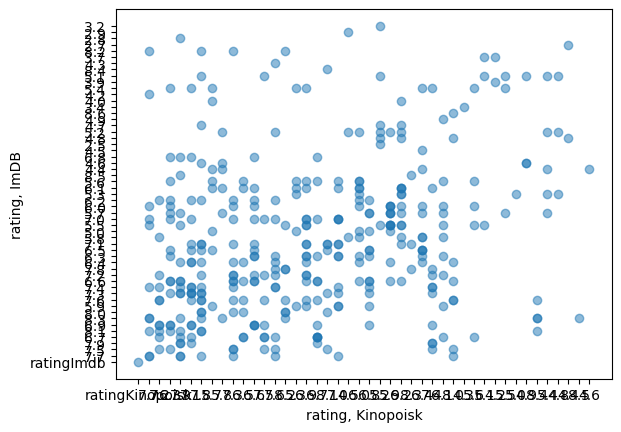

In [70]:
# Сравним оценки из Кинопоиска, ratingBig (+цвет - ratingImdb imdb)
fig, ax = plt.subplots()
scores = kinopoiks_imdb_netflix.dropna(subset=['ratingKinopoisk', 'ratingImdb'])
# scores['ratingKinopoisk'].astype(float)
# scores['ratingImdb'].astype(float)

# TODO сделать нормальный график
ax.scatter(scores.ratingKinopoisk, scores.ratingImdb, alpha=0.5)

ax.set_xlabel('rating, Kinopoisk')
ax.set_ylabel('rating, ImDB')